In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def random_orthogonal_basis(k, attack=False):
    """
    Generates a random orthogonal basis for R^k.

    Parameters:
    k (int): Dimension of the space.

    Returns:
    np.ndarray: A k x k orthogonal matrix whose columns form an orthogonal basis.
    """
    # Generate a random k x k matrix with entries from a standard normal distribution
    A = np.random.randn(k, k)
    if attack:
        # correct A to start with the cursed vector
        A[:,0] = -np.ones(k)
        A[0,0] = k**(1/2)
        A[:,1] = 0
        A[0,1] = 1
        A = A.T
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

def gram_schmidt(A):
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

# Example usage:
k = 100  # Dimension of the space
basis = random_orthogonal_basis(k)
print(f"Random orthogonal basis for R^{k}:")

Random orthogonal basis for R^100:


In [3]:
def inf(matrix):
    """
    Computes the infinity norm of a matrix.

    Parameters:
    matrix (array-like): A 2D list or NumPy array representing the matrix.

    Returns:
    float: The infinity norm of the matrix.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix)
    
    # Compute the infinity norm
    rowsinf = np.sum(np.abs(matrix), axis=1)
    
    infinity_norm = np.max(rowsinf) # np.sort(np.sum(np.abs(matrix), axis=1))[int(k-1)] #
    idx = np.argmax(rowsinf)
    return infinity_norm, idx

In [10]:
def get_fourier(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = np.cos(i*x)/(k**0.5)
    return mat

def get_poly(k):
    mat = np.zeros((k,k))
    x = 2*np.arange(k)/k-1
    for i in range(k):
        mat[:,i] = x**i/(k**0.5)
    return mat


[[ 1.  0. -0. -0. -0.]
 [ 0.  1.  0.  0. -0.]
 [-0.  0.  1. -0. -0.]
 [-0.  0. -0.  1.  0.]
 [-0. -0. -0.  0.  1.]]


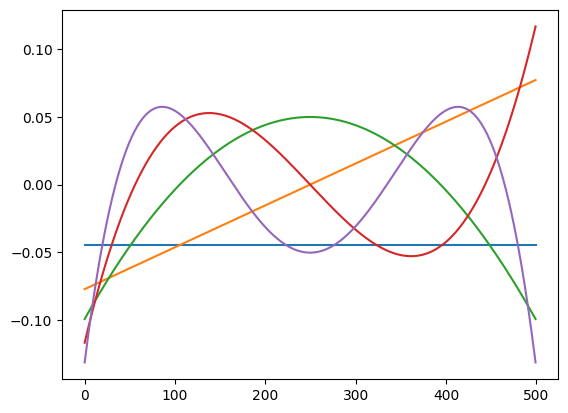

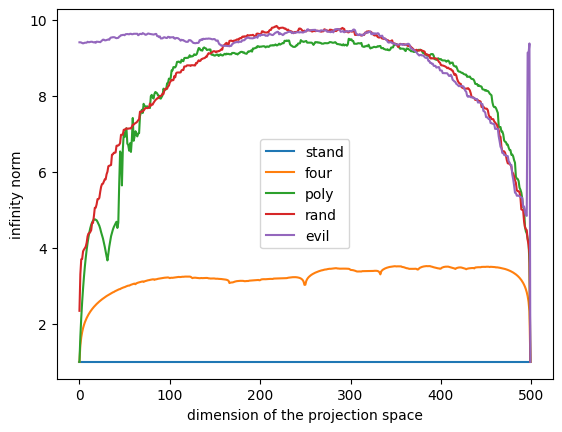

In [13]:
k = 500
x = np.arange(k)
basis_stand = np.identity(k)
basis_four = gram_schmidt(get_fourier(k))
basis_poly = gram_schmidt(get_poly(k))
basis_rand = random_orthogonal_basis(k)
basis_evil = random_orthogonal_basis(k, attack=True)

print(np.round(np.dot(basis_poly[:,:5].T,basis_poly[:,:5]), 3))

for i in range(5):
    plt.plot(basis_poly[:,i])
plt.show()

basis_list = [basis_stand, basis_four, basis_poly, basis_rand, basis_evil]
labels = ['stand', 'four', 'poly', 'rand', 'evil']

for i in range(len(basis_list)):   

    # choose the basis
    basis = basis_list[i]
    mat = np.zeros((k,k))

    # infnorms collects the infinity norm of the matrices
    infnorms = np.zeros(k)

    for d in range(k):

        # we incrementally update the matrix adding more and more basis functions
        mat += np.dot(basis[:,d:d+1], basis[:,d:d+1].T)
        infnorms[d], _ = inf(mat)

    plt.plot(x, infnorms, label = labels[i])


plt.legend()
plt.xlabel('dimension of the projection space')
plt.ylabel('infinity norm')
plt.show()

In [102]:
N = 4000
ang = np.linspace(0,np.pi/2,N)
max_norm = 0
max_ang = 0
d = 20
J = d-2
kmax = 0

for i in range(N):
    angle = ang[i]
    U = get_rotation_matrix(d=d, i=0, j=1, angle=angle)
    for j in range(J):
        U2 = get_rotation_matrix(d=d, i=0, j=2+j, angle=angle)
        U = np.dot(U,U2)

    for k in range(d-1):
        Z = np.dot(U,U2)[:,:k]
        proj = np.dot(Z,Z.T)
        norm, vec = inf(proj)

        if norm > max_norm:
            max_norm = norm
            max_ang = angle
            max_k = k

print(max_norm, max_ang*(180/np.pi), max_k)

# in case of disjoint angles: take the maximum of the axes

2.6744654107594172 80.66016504126031 1


In [93]:
angle = 0*np.pi/16
angle1 = 6*np.pi/16

U = get_rotation_matrix(d=d, i=0, j=d-2, angle=angle)
U2 = get_rotation_matrix(d=d, i=0, j=d-1, angle=angle1)
Z = np.dot(U,U2)[:,:1]
proj = np.dot(Z,Z.T)
norm, vec = inf(proj)
norm

1.2071067811865475

In [6]:
def get_rotation_matrix(d, i, j, angle):
    if i>d-1 or j>d-1:
        raise ValueError("indexes must be in range(d)")
    mat = np.eye(d)
    mat[i,i] = np.sin(angle)
    mat[i,j] = np.cos(angle)
    mat[j,i] = np.cos(angle)
    mat[j,j] = -np.sin(angle)
    return mat

In [35]:
def test_submodularity(basis, iter=1000):
    k = basis.shape[1]
    maxim = -100
    for i in range(iter):
        mat = []
        vec = []
        rs = np.random.choice(k,size=3,replace=False)

        for i in range(3):
            r = rs[i]
            vec.append(basis[:,r])
            mat.append(np.dot(basis[:,r:r+1], basis[:,r:r+1].T))
        
        z = inf(mat[0]+mat[1]+mat[2]) - inf(mat[0]+mat[1]) - inf(mat[0]+mat[2]) + inf(mat[0])
        if z > maxim:
            maxim = z
            retvecs = vec
    
    return maxim, retvecs
        


In [36]:
k = 4
vecs = []
maxim = 0
for _ in range(1000):
    basis = random_orthogonal_basis(k)
    z, vecs = test_submodularity(basis, iter=min(1000,k**3))
    if z > maxim:
        retvecs = vecs
        maxim = z


In [36]:
## create random basis of dimension k
k = 200
d = 50
basis = random_orthogonal_basis(k)
starting_matrix = np.dot(basis[:,:d],basis[:,:d].T)
print(inf(starting_matrix))

5.862956939070147


In [7]:
## this time we add, at each time, the matrix which maked the infinity norm smaller

def choose_f(M, vectors):
    mio = 100000
    idx = 0
    for i in range(vectors.shape[1]):
        v = vectors[:,i:i+1]
        info = inf(M+np.dot(v,v.T))
        if info < mio:
            mio = info
            idx = i
    return idx, info

def build_low_mat(basis, d):
    idx = 0
    M = np.zeros((basis.shape[0],basis.shape[0]))
    residual = np.copy(basis)
    for i in range(d):
        v = residual[:,idx:idx+1]
        M += np.dot(v,v.T)
        residual = np.hstack((residual[:,:idx], residual[:,idx+1:]))
        idx, info = choose_f(M, residual)
    return info

k = 200
d = 100
basis = random_orthogonal_basis(k)


starting_matrix = np.dot(basis[:,:d],basis[:,:d].T)
print(inf(starting_matrix))
print(build_low_mat(basis, d))

6.4423933847542925
6.271312915422958


In [11]:


def compute_w_proj(V,W):

    # compute inner matrix that is going to be inverted
    Inner = np.dot(V.T,np.dot(W,V))
    In = np.linalg.inv(Inner)

    # compute actual projection matrix
    P = np.dot(np.dot(V, np.dot(In, V.T)), W)
    return P

def matrix_derivarive(V, W):

    # compute inner matrix that is going to be inverted
    Inner = np.dot(V.T,np.dot(W,V))
    In = np.linalg.inv(Inner)

    # compute actual projection matrix
    P = np.dot(np.dot(V, np.dot(In, V.T)), W)

    
    return P

In [9]:
W = np.eye(k)/k

compute_w_proj(basis, W).shape

(200, 200)

In [35]:
# test convexity. We choose some data distribution to show that the 
# weighted infinity norm is *not* a convex function of the (vector-valued) input
import numpy as np

def test_conv(f, d, samp=1000):
    rands = np.random.uniform(size=(samp,d))
    sums = np.sum(rands, axis=1)
    sums = sums[:, np.newaxis]
    rands = rands/sums

    fvec = np.zeros(samp)
    fvec[0] = f(rands[0,:])

    for i in range(samp-1):
        fvec[i+1] = f(rands[i+1,:])

        mean = (rands[i] + rands[i+1])/2
        if f(mean) > (fvec[i] + fvec[i+1])/2:
            print(f(mean) - (fvec[i] + fvec[i+1])/2)
            return False
    
    return True

def fun(x):
    return x[0] + x[1] + x[1]**2

test_conv(fun, 2)


True

In [44]:
#### define the function giving the effectiveness of every data distribution
k = 100
d = 30
basis = random_orthogonal_basis(k=k)

# orthogonal matrix
V = basis[:,:d]

def compute_w_proj(V,W):

    # compute inner matrix that is going to be inverted
    Inner = np.dot(V.T,np.dot(W,V))
    In = np.linalg.inv(Inner)

    # compute actual projection matrix
    P = np.dot(np.dot(V, np.dot(In, V.T)), W)
    return P


# mu given distribution on the k elelments
def optimizer(w):
    W = np.diag(w)
    Mat = compute_w_proj(V,W)
    return inf(Mat)
    

In [45]:
test_conv(optimizer, d=k)

True

In [ ]:
def valle_poussin(rho, basis, d):
    '''
    rho: weights (length D)
    basis: ALL the elements that we are going to consider
    d: the first d are already in, we cannot do anything about it
    '''
    D = len(rho)
    M = np.dot(basis[:,:d],basis[:,:d].T)
    print('initial guess: '+str(inf(M)))
    for r in range(d+1,d+D+1):
        v = basis[:,r]
        v = v[:,np.newaxis]
        M += rho[r-d-1]*np.dot(v, v.T)
    return inf(M)


k = 100
basis = random_orthogonal_basis(k, attack=True)
d = 1
D = 5
rho = np.ones(D)
valle_poussin(rho, basis, d)

initial guess: (4.580425715786257, 0)


(4.485206768404949, 0)

In [31]:
def objective_fun(M, rho, basis, d):
    '''
    rho: weights (length D)
    basis: ALL the elements that we are going to consider
    d: the first d are already in, we cannot do anything about it
    '''
    D = len(rho)
    for r in range(d+1,d+D+1):
        v = basis[:,r]
        v = v[:,np.newaxis]
        M += rho[r-d-1]*np.dot(v, v.T)
    return inf(M)


def get_gradient(M, rho, basis, d, j):
    '''
    Compute the derivative of the infinity norm w.r.t.
    component j
    '''
    D = len(rho)
    for r in range(d+1,d+D+1):
        v = basis[:,r]
        v = v[:,np.newaxis]
        M += rho[r-d-1]*np.dot(v, v.T)


    load = 0
    m = 0
    for n in range(M.shape[1]):
        if M[n,m] > 0:
            load += basis[m,j]*basis[n,j]
        else:
            load = basis[m,j]*basis[n,j]

    return load



def optimizer(M, basis, d, D, iter=100, lr=0.1):

    rho = np.ones(D)

    for it in range(iter):
        grad = np.zeros(D)
        for j in range(D):
            grad[j] = get_gradient(np.copy(M), rho, basis, d, D+j)
        rho = rho - lr*grad
        print('Objective function: '+str(objective_fun(np.copy(M), rho, basis, d)))

k = 100
basis = random_orthogonal_basis(k, attack=True)
d = 1
M = np.dot(basis[:,:d],basis[:,:d].T)
D = 10
optimizer(M, basis, d, D)

Objective function: (4.268688556483643, 0)
Objective function: (4.268899688298416, 0)
Objective function: (4.2691108201131875, 0)
Objective function: (4.2693219519279575, 0)
Objective function: (4.26953308374273, 0)
Objective function: (4.269744215557502, 0)
Objective function: (4.2699553473722744, 0)
Objective function: (4.270166479187046, 0)
Objective function: (4.270377611001819, 0)
Objective function: (4.27058874281659, 0)
Objective function: (4.270799874631362, 0)
Objective function: (4.271011006446133, 0)
Objective function: (4.271222138260904, 0)
Objective function: (4.2714332700756765, 0)
Objective function: (4.271644401890448, 0)
Objective function: (4.271855533705222, 0)
Objective function: (4.272067141768398, 0)
Objective function: (4.272327051401739, 0)
Objective function: (4.27258696103508, 0)
Objective function: (4.27284687066842, 0)
Objective function: (4.273106780301762, 0)
Objective function: (4.273366689935104, 0)
Objective function: (4.273626599568445, 0)
Objective f